In [1]:
import pandas as pd
import pymysql
import logging
import sshtunnel
from sshtunnel import SSHTunnelForwarder
import os.path
import matplotlib.pyplot as plt
import numpy as np
import os 
from collections import Counter

In [2]:
# You will need to add your SSH public key and database password to connect.
ssh_host = 'vfsmghnecweb01.fsm.northwestern.edu'
ssh_username = 'efa3001'
db_server = 'vfsmghnecdb01.fsm.northwestern.edu'
database_username = 'efa3001'
ssh_pkey = 'C:\\Users\\16262\\Desktop\\NCDS-NEC_Data_Internship\\5-16-privkey-openSSH'
database_password = 'E%H2)h.nPevc<a>&'
database_name = 'nec_dw'
localhost = '127.0.0.1'

In [3]:
def open_ssh_tunnel(verbose=False):
    """Open an SSH tunnel and connect using a username and password.
    
    :param verbose: Set to True to show logging
    :return tunnel: Global SSH tunnel connection
    """
    
    if verbose:
        sshtunnel.DEFAULT_LOGLEVEL = logging.DEBUG
    
    global tunnel
    tunnel = SSHTunnelForwarder(
        (ssh_host, 22),
        ssh_username = ssh_username,
        ssh_pkey = ssh_pkey,
        remote_bind_address = (db_server, 3306)
    )
    
    tunnel.start()

In [4]:
def mysql_connect():
    """Connect to a MySQL server using the SSH tunnel connection
    
    :return connection: Global MySQL database connection
    """
    
    global connection
    
    connection = pymysql.connect(
        host = localhost,
        user = database_username,
        passwd = database_password,
        db = database_name,
        port = tunnel.local_bind_port
    )

In [5]:
def run_query(sql):
    """Runs a given SQL query via the global database connection.
    
    :param sql: MySQL query
    :return: Pandas dataframe containing results
    """
    
    return pd.read_sql_query(sql, connection)

In [6]:
def mysql_disconnect():
    """Closes the MySQL database connection.
    """
    
    connection.close()

In [7]:
def close_ssh_tunnel():
    """Closes the SSH tunnel connection.
    """
    
    tunnel.close

In [8]:
open_ssh_tunnel()

In [9]:
mysql_connect()

In [10]:
##Below: Exploring the relationship between Funding and Success Ratings for Staff Activities (StA)

In [11]:
#grabbing Staff Activities table
staff_df = run_query("SELECT * FROM StaffActivities")
#staff_df.head()

In [12]:
#removing null success values
staff_success_df = staff_df[staff_df["ActivityHowSuccessfulID"] > 0.0]

In [13]:
#checking if each activity ID is unique
unique_activity = staff_success_df["ActivityID"].unique()
len(unique_activity)
#yes!

3734

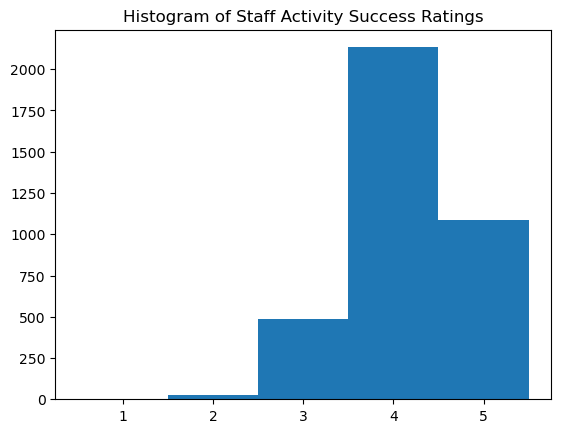

In [14]:
##lets look at the distribution for success in staff activities?
plt.title("Histogram of Staff Activity Success Ratings")
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
x = [staff_success_df["ActivityHowSuccessfulID"]]
my_bins = np.arange(6)+0.5
plt.hist(x, my_bins)
plt.show()

In [15]:
##looking specifically at activity ID, success, and non-NLM funding amount
staff_success_funds_df = staff_success_df[["ActivityID","ActivityHowSuccessfulID","NonNLMFundingAmount"]]
#staff_success_funds_df

In [16]:
##How is nonNLMFundingAmount per success rank?
describe_fund_success = staff_success_funds_df.groupby(["ActivityHowSuccessfulID"])["NonNLMFundingAmount"].describe()
describe_fund_success
#note the count distribution of success ratings.

,count,mean,std,min,25%,50%,75%,max
ActivityHowSuccessfulID,,,,,,,,
1.0,2.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2.0,27.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3.0,485.0,0.494845,10.897839,0.0,0.0,0.0,0.0,240.0
4.0,2133.0,3.383029,91.999761,0.0,0.0,0.0,0.0,3434.0
5.0,1087.0,13.477461,232.223901,0.0,0.0,0.0,0.0,5300.0


In [17]:
##Below: looking at funding and success for subaward activities (SuA)
#to-do: clean ProjectSummary in order to identify any prominent terms
#1. clean ProjectSummary
#2. group funding by bins
#3. identify most prevalent term in each funding bin

In [18]:
#join ProjectFunding to Projects to SubawardActivities
#grabbing Subaward Activites, Projects, and Project Funding Tables
sub_df, sub_proj_df, sub_proj_fund_df = run_query("SELECT * FROM SubawardActivities"), run_query("SELECT * FROM Projects"), run_query("SELECT * FROM ProjectFunding")

In [19]:
sub_df.head()

,ActivityID,Title,RegionOfficeID,ProjectID,Description,StartDate,EndDate,Status,ActivityWasConductedOnline,ActivityWasConductedInPerson,...,TrainingWasProvided,AddressStreet,AddressApartmentSuite,AddressCity,AddressState,Zip,116CongressDistrict,GeocodedLatitude,GeocodedLongitude,ModifiedDate
0,9654,All of Us; New York-New Jersey Chapter of the ...,3,9630.0,The purpose of this activity was to present up...,2018-10-24,2018-10-24,Accept and Add Staff Data,0,1,...,0.0,33 West 42nd Street,,New York,NY,10036,None,None,None,2020-03-07
1,9822,2018 Shale & Public Health Conference,3,9687.0,This tabling activity was available from 9am-5...,2018-11-14,2018-11-14,Accept and Add Staff Data,0,1,...,0.0,123 University Place,,Pittsburgh,PA,15260,None,None,None,2020-03-07
2,9857,Madison Country Day School Research Sessions P...,2,9765.0,The primary objective of this activity was to ...,2019-02-08,2019-02-08,Accept and Add Staff Data,0,1,...,1.0,750 Highland Av,,Madison,WI,53705,None,None,None,2019-01-01
3,10028,Viking Library System Training consumer health,2,9762.0,"Erika Johnson, Fargo, ND, spent two hours with...",2019-03-27,2019-03-27,Accept and Add Staff Data,0,1,...,1.0,Fergus Falls Public Library,205 E Hampden Ave.,Fergus Falls,MN,56537,None,None,None,2019-01-01
4,10158,SIU 3D Printing Program 17 Jan 2019,2,9782.0,The SIU Med 3D Printing Program met with the R...,2019-01-17,2019-01-17,Accept and Add Staff Data,0,1,...,1.0,801 N. Rutledge,,Springfield,IL,62794,None,None,None,2019-01-01


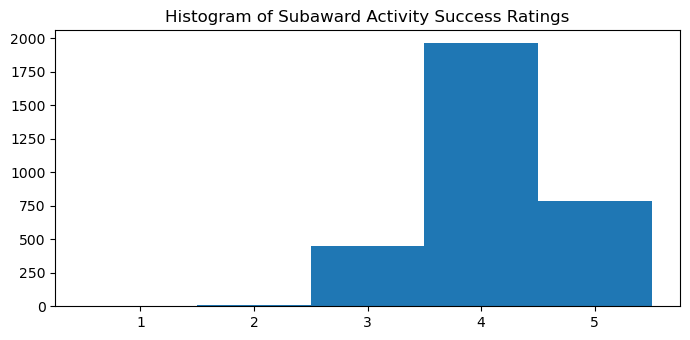

In [20]:
##lets look at the success distribution for subaward activities as well! 

plt.title("Histogram of Subaward Activity Success Ratings")
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
x = [sub_df["ActivityHowSuccessfulID"]]
my_bins = np.arange(6)+0.5
plt.hist(x, my_bins)
plt.show()

#it's about the same as the staff award activity success

In [21]:
##checking if a project has multiple activities... yes!
len(sub_df["ProjectID"].unique())
#how to split success rating by different activities from same funding?
#1. try: success rating average for activities belonging to the same project and fund?

995

In [22]:
#projectfunding is separated into columns by year, so a project may span several years.
#for projects that span several years, do success ratings improve with funding?

In [23]:
##group projects into mean funding and add Project ID
mean_proj_fund_df = sub_proj_fund_df.groupby(["ProjectID"])["FundingAmount"].mean().to_frame().rename(columns={"FundingAmount":"MeanFunding"})
title_proj_df = run_query("SELECT ProjectID, Title, ProjectSummary FROM Projects")
sub_proj_summ_and_fund_df = mean_proj_fund_df.merge(title_proj_df, how = "left", on = "ProjectID")
sub_proj_summ_and_fund_df.head()

,ProjectID,MeanFunding,Title,ProjectSummary
0,9630,16070.0,All of Us - The All of Us Research Program and...,The National Institutes of Health and the Nati...
1,9651,4941.0,Seeds of Hope,The Clinton-Essex-Franklin Library System (CEF...
2,9683,20000.0,Resources and Services for Community Health Nu...,To support community health nurses across the ...
3,9687,16338.0,Clinical and Public Health Approaches for Comm...,Southwest Pennsylvania Environmental Health Pr...
4,9698,40445.5,Arizona Outreach (2016-2021),This project focuses on key health priorities ...


In [24]:
##what are the top five and lowest five projects (that are not 0 or 1) in mean funding overall?
sub_proj_summ_and_fund_df.sort_values("MeanFunding", ascending = False)[sub_proj_summ_and_fund_df["MeanFunding"] > 1]

,ProjectID,MeanFunding,Title,ProjectSummary
5191,1016287,1.743835e+06,Connect to your Health Wellness Fair,DESCRIPTION: As one of the largest consumers o...
2207,1003494,1.655812e+06,National Network of Libraries of Medicine Sout...,DESCRIPTION: The University of Maryland Health...
4828,1013322,1.555585e+06,"NN/LM South Central Region, 2016-2021",DESCRIPTION: The Gibson D. Lewis Health Scienc...
3431,1005001,1.498588e+06,National Network of Libraries of Medicine Sout...,DESCRIPTION: The University of Maryland Health...
4813,1013032,1.484613e+06,NN/LM Pacific NW Region 2016-2021,DESCRIPTION: The mission of the National Netwo...
...,...,...,...,...
4453,1010929,6.600000e+01,Exhibitor: National MS Society Upstate New Yor...,DESCRIPTION: Funds will support The Capital Di...
1322,1002436,6.250000e+01,Exhibit Award: Minnesota-2002 Minnesota 4TH Te...,"DESCRIPTION: Exhibit Award: Lisa McGuire, Jame..."
1451,1002574,5.150000e+01,Exhibit Award - WXII Healthy Living Fair 2004,DESCRIPTION: Exhibit at the WXII Healthy Livin...
1809,1003032,3.750000e+01,Exhibit Award: 2002 American Indian Higher Edu...,DESCRIPTION: Exhibit Award: to exhibit at the ...


In [25]:
##what is the relationship between mean project funding (across years) to project's mean activity success rating?
sub_success_df = run_query("SELECT ActivityID, ProjectID, ActivityHowSuccessfulID FROM SubawardActivities")
sub_success_pos_df = sub_success_df[sub_success_df["ActivityHowSuccessfulID"]>0]
sub_mean_success_df = sub_success_pos_df.groupby("ProjectID")["ActivityHowSuccessfulID"].mean().to_frame()
sub_fund_mean_success_df = sub_mean_success_df.merge(sub_proj_summ_and_fund_df, how = "inner", on = "ProjectID")
sub_fund_mean_success_df.sort_values("MeanFunding", ascending = False)

,ProjectID,ActivityHowSuccessfulID,MeanFunding,Title,ProjectSummary
416,30397.0,4.000000,261930.0,Citizen Science Month 2021,The Network of the National Library of Medicin...
419,31469.0,3.666667,163993.0,Health and Wellness Conversations at Your Library,StoryCorps and the National Network of Librari...
377,28243.0,4.000000,138805.5,AgriSafeHealthHub (AHH),The purpose of the NLM funded project is to cr...
245,17467.0,3.179487,102708.5,Employing Community Wellness Liaisons to Creat...,This project has been designed by the Communit...
264,19867.0,3.240000,100394.0,JUNTOS por su SALUD: Librarians and Health Pro...,The purpose is to increase the access of Spani...
...,...,...,...,...,...
12,9755.0,4.500000,0.0,Partner Outreach 2018-2021: University of Loui...,"Serve as a partner outreach library, offering ..."
14,9762.0,4.000000,0.0,Partner Outreach 2018-2021: University of Nort...,"Serve as a partner outreach library, offering ..."
15,9765.0,3.500000,0.0,Partner Outreach 2018-2021: University of Wisc...,"Serve as a partner outreach library, offering ..."
16,9772.0,4.333333,0.0,Partner Outreach 2018-2021: University of Cinc...,"Serve as a partner outreach library, offering ..."


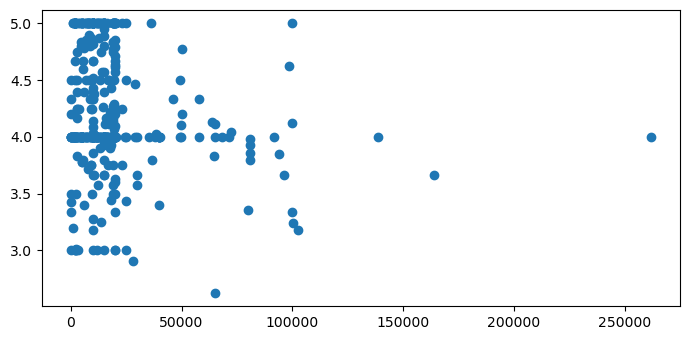

In [26]:
plt.scatter(sub_fund_mean_success_df["MeanFunding"], sub_fund_mean_success_df["ActivityHowSuccessfulID"])

In [27]:
##PLOT thoughts
#looks like funding does not directly impact success? Maybe success rating is too biased?

In [28]:
##Saving sub_projects_and_mean_funding_df to look through in OpenRefine 

# file_path = "C:\\Users\\16262\\Desktop\\ncds"

# if not os.path.exists(file_path):
#      os.mkdir(file_path)

# output_file = 'subaward_project_summaries_and_mean_funding_df.tsv'
# complete_fn = os.path.join(file_path, output_file)
# sub_proj_summ_and_fund_df.to_csv(complete_fn, sep = '\t',index=False)

In [29]:
##Removing "filler" words in Title and Project Summary into new df, sub_proj_main_df
#why do we use sub_proj_summ_and_fund_df here rather than the success rating (sub_fund_mean_success_df)? 
#success seems to be subjective, and the sub_fund_mean_success_df is much smaller.
sub_proj_main_df = sub_proj_summ_and_fund_df
# filler_words = ["The","the","and","on","of","to","will","in","a",
#                 "DESCRIPTION:","for","with","be","is",":","at","as","by",
#                "that","their", "REMARKS:", "an", "This", "this", "n",
#                "are", "use", "from", "other", "URL:", "PIEmailAddress:",
#                "PITelephone:", "PIFirstName:", "PILastName:", "about", "through",
#                "or", "our", "To", "project", "have", "how", "who", "AwardType:", "also",
#                "health", "information", "Health", "Library", "Us", "All", "NN/LM",
#                "Libraries", "offer"]

## am trying to remove all common words to better identify differences between ranges, rather than just filler words
common_words_list = Counter(" ".join(sub_proj_main_df['ProjectSummary']).split()).most_common(250)
special_words = ['library,','*','I','Library,']
#special_words accomodates for words that should have been dropped but weren't due to formatting issues
filler_words = [tupleObj[0] for tupleObj in common_words_list]
filler_words.extend(special_words)
print(filler_words)

['and', 'the', 'to', 'of', 'will', 'in', 'health', 'a', 'for', 'The', 'DESCRIPTION:', 'information', 'with', 'be', 'on', 'is', 'Health', 'Library', 'at', 'as', 'project', 'by', 'resources', 'that', 'their', 'access', 'provide', 'training', 'community', 'library', 'this', 'n', 'public', 'REMARKS:', 'an', 'This', 'are', 'use', 'from', 'NLM', 'other', 'URL:', 'staff', 'PIEmailAddress:', 'PITelephone:', 'outreach', 'Training:', 'PIFirstName:', 'PILastName:', 'support', 'University', 'AwardType:', 'about', 'through', 'services', 'our', 'Medical', 'program', 'or', 'National', 'education', 'students', 'literacy', 'care', 'Medicine', 'medical', 'Center', 'have', 'awareness', 'libraries', 'award', 'online', 'how', 'Public', 'who', 'improve', 'promote', 'librarians', 'providing', 'also', 'professionals', 'available', 'can', '-', 'research', 'which', 'Outreach', 'has', 'goal', 'increase', 'develop', 'data', 'local', 'these', 'members', 'All', 'Information', 'In', 'well', 'Project', 'using', 'Comm

In [30]:
#source: https://stackoverflow.com/questions/55533962/removing-specific-word-in-a-string-in-pandas
filler_words = set(filler_words)
drop = lambda x: ' '.join(w for w in x.split() if not w in filler_words)
sub_proj_main_df['ShortSum'] = sub_proj_main_df['ProjectSummary'].apply(drop)
sub_proj_main_df.sort_values("MeanFunding", ascending = False).head()

,ProjectID,MeanFunding,Title,ProjectSummary,ShortSum
5191,1016287,1.743835e+06,Connect to your Health Wellness Fair,DESCRIPTION: As one of the largest consumers o...,"As largest healthcare, senior adults often lef..."
2207,1003494,1.655812e+06,National Network of Libraries of Medicine Sout...,DESCRIPTION: The University of Maryland Health...,Maryland Human Services Regional 2006-2011 con...
4828,1013322,1.555585e+06,"NN/LM South Central Region, 2016-2021",DESCRIPTION: The Gibson D. Lewis Health Scienc...,Gibson D. Lewis North Texas (UNTHSC) Regional ...
3431,1005001,1.498588e+06,National Network of Libraries of Medicine Sout...,DESCRIPTION: The University of Maryland Health...,Maryland Human Services Regional 2011-2016 con...
4813,1013032,1.484613e+06,NN/LM Pacific NW Region 2016-2021,DESCRIPTION: The mission of the National Netwo...,mission (NN/LM) advance progress medicine 1) U...


In [31]:
##counter of most common words to help remove fillers
#source: https://stackoverflow.com/questions/29903025/count-most-frequent-100-words-from-sentences-in-dataframe-pandas
#Counter(" ".join(sub_proj_main_df['ShortSum']).split()).most_common(5)

In [32]:
#deciding on histogram bin width
funding_bins=(np.arange(11)+1)**6
#funding_bins

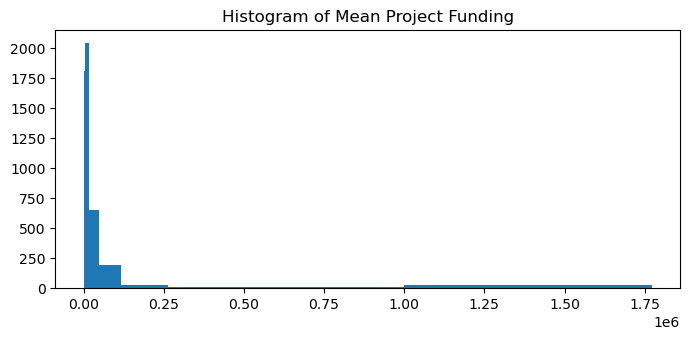

In [33]:
#create histogram for funding to determine funding ranges.
plt.title("Histogram of Mean Project Funding")
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
x = [sub_proj_main_df['MeanFunding']]
plt.hist(x, funding_bins)
plt.show()

In [34]:
#MeanFunding == 1 will be sorted with 0s as it seems to be an error
#taking a look at projects with funding less than 64 but greater than 1
sub_proj_main_df[(sub_proj_main_df['MeanFunding']<64) & (sub_proj_main_df['MeanFunding']>1)]

,ProjectID,MeanFunding,Title,ProjectSummary,ShortSum
1223,1002327,29.5,Professional Development Award - Halifax Medic...,DESCRIPTION: Addajane Wallace will attend the ...,Addajane Wallace Creating Documents Palm OS Ha...
1322,1002436,62.5,Exhibit Award: Minnesota-2002 Minnesota 4TH Te...,"DESCRIPTION: Exhibit Award: Lisa McGuire, Jame...","Award: Lisa McGuire, James Beattie, Cynthia Ro..."
1451,1002574,51.5,Exhibit Award - WXII Healthy Living Fair 2004,DESCRIPTION: Exhibit at the WXII Healthy Livin...,"WXII Healthy Living Fair, Winston-Salem, NC, F..."
1809,1003032,37.5,Exhibit Award: 2002 American Indian Higher Edu...,DESCRIPTION: Exhibit Award: to exhibit at the ...,Award: Indian Higher Education Consortia Confe...


In [35]:
##what are the most frequent words in description per funding level? apply function while grouping.
#1. add column "FundingBin" that follows funding_bins
#2. group funding_bins together and apply counter to each bin

In [36]:
def to_the_bin(num):
    """
    to assign a bin value for the number up to largest number in funding_bins.
    
    Arguments: a number, int or float
    
    Returns: bin value containing the number, upper bound. however, nums from 0 to (and including) 1 will be in the bin 0.
    
    """
    cap = 0
    count = 0
    for y in funding_bins:
        count+=1
        if (num > y):
            cap = funding_bins[count]
    return cap

In [37]:
##testing to_the_bin()
#to_the_bin(8)

In [38]:
#step 1
sub_proj_main_df["FundingBin"] = sub_proj_main_df["MeanFunding"].apply(to_the_bin)
sub_proj_main_df.sort_values("MeanFunding", ascending = False)

,ProjectID,MeanFunding,Title,ProjectSummary,ShortSum,FundingBin
5191,1016287,1.743835e+06,Connect to your Health Wellness Fair,DESCRIPTION: As one of the largest consumers o...,"As largest healthcare, senior adults often lef...",1771561
2207,1003494,1.655812e+06,National Network of Libraries of Medicine Sout...,DESCRIPTION: The University of Maryland Health...,Maryland Human Services Regional 2006-2011 con...,1771561
4828,1013322,1.555585e+06,"NN/LM South Central Region, 2016-2021",DESCRIPTION: The Gibson D. Lewis Health Scienc...,Gibson D. Lewis North Texas (UNTHSC) Regional ...,1771561
3431,1005001,1.498588e+06,National Network of Libraries of Medicine Sout...,DESCRIPTION: The University of Maryland Health...,Maryland Human Services Regional 2011-2016 con...,1771561
4813,1013032,1.484613e+06,NN/LM Pacific NW Region 2016-2021,DESCRIPTION: The mission of the National Netwo...,mission (NN/LM) advance progress medicine 1) U...,1771561
...,...,...,...,...,...,...
102,10202,0.000000e+00,Medical Data and Me Community Awareness,Medical Data and Me Community Awareness Projec...,Data Me Awareness Project: partners series int...,0
859,34355,0.000000e+00,test2,testing how this used to work,testing,0
2503,1003878,0.000000e+00,Go Local for Central Texas,DESCRIPTION: The Texas A&M University Medical ...,Texas A&M maintain Go Local site 22 counties C...,0
5081,1015206,0.000000e+00,Outreach Library 2017-2018: University of Iowa...,DESCRIPTION: Serve as a partner outreach libra...,Serve offering promotion behalf GMR. Serve off...,0


In [39]:
#step 2

#source: https://thispointer.com/get-every-second-element-from-a-list-of-tuples-in-python/
#source: https://towardsdatascience.com/applying-custom-functions-to-groups-of-data-in-pandas-928d7eece0aa

common_list = Counter(" ".join(sub_proj_main_df['ShortSum']).split()).most_common(50)
words_list = [tupleObj[0] for tupleObj in common_list]
counts_list = [tupleObj[1] for tupleObj in common_list]

def key_words(df, col):
    """
    joins the specified (col) column cells for each group, 
    and identifies the five most common words in that group.
    
    to use: df.groupby(...).apply(common_word, col = '...')
    
    arguments: pd dataframe, string column name
    
    returns: a list of tuples of the five most common words 
    for this group and their counts.
    """
    common_list = Counter(" ".join(df[col]).split()).most_common(5)
    return (common_list)


In [40]:
descr_bins_funds_df = sub_proj_main_df.groupby(['FundingBin'])["MeanFunding"].describe()
descr_bins_funds_df

,count,mean,std,min,25%,50%,75%,max
FundingBin,,,,,,,,
0,62.0,1.129032e-01,0.319058,0.000000e+00,0.000,0.000000e+00,0.000000e+00,1.000000e+00
64,4.0,4.525000e+01,14.660036,2.950000e+01,35.500,4.450000e+01,5.425000e+01,6.250000e+01
729,485.0,4.157662e+02,168.874977,6.600000e+01,250.000,4.640000e+02,5.090000e+02,7.285000e+02
4096,1809.0,1.813337e+03,774.409800,7.340000e+02,1222.000,1.655000e+03,2.099000e+03,4.092000e+03
15625,2045.0,8.688366e+03,3719.139004,4.100000e+03,5000.000,7.790600e+03,1.200000e+04,1.551000e+04
46656,650.0,2.529321e+04,7971.391504,1.567200e+04,19727.000,2.334650e+04,2.933388e+04,4.650000e+04
117649,193.0,6.818111e+04,20169.251997,4.674600e+04,50000.000,6.000000e+04,8.071000e+04,1.176114e+05
262144,22.0,1.699865e+05,43965.949721,1.178367e+05,138448.875,1.610902e+05,1.954642e+05,2.619300e+05
531441,8.0,3.467877e+05,58584.054094,2.899380e+05,313302.500,3.252300e+05,3.582310e+05,4.646757e+05


In [41]:
pd.set_option("max_colwidth", None)
sub_bins_and_words_df = sub_proj_main_df.groupby(['FundingBin']).apply(key_words, col = 'ShortSum').to_frame()
sub_bins_and_words_df.rename(columns={sub_bins_and_words_df.columns[0]:'SummaryKeyWords'}, inplace=True)

sub_bins_and_title_df = sub_proj_main_df.groupby(['FundingBin']).apply(key_words, col = 'Title').to_frame()
sub_bins_and_title_df.rename(columns={sub_bins_and_title_df.columns[0]:'TitleKeyWords'}, inplace=True)

#sub_bins_and_title_df
sub_bins_and_words_df

,SummaryKeyWords
FundingBin,
0,"[(behalf, 37), (offering, 25), (promotion, 25), (Serve, 24), (GMR., 24)]"
64,"[(Wallace, 2), (ProfessionalTargetPopHPStudents:, 2), (Award:, 2), (Winston-Salem,, 2), (Addajane, 1)]"
729,"[(ProfessionalTargetPopPharm:n, 71), (ProfessionalTargetPopHPStudents:, 62), (Conference, 44), (Electronic, 43), (meeting, 42)]"
4096,"[(NIH, 149), (Award:, 134), (October, 133), (Conference, 127), (meeting, 93)]"
15625,"[(mobile, 136), (databases., 126), (databases, 126), (primary, 125), (minority, 120)]"
46656,"[(management, 69), (build, 64), (Access, 63), (digital, 63), (series, 62)]"
117649,"[(biomedical, 44), (Resource, 40), (AIDS, 37), (HIV, 35), (network, 30)]"
262144,"[(MCR, 10), (Engagement, 7), (game, 6), (practices, 5), (AgriSafe, 5)]"
531441,"[(evaluation, 16), (NEO, 9), (RML, 6), ((Aim, 5), (members., 4)]"


In [42]:
bins_keys_count_df = sub_bins_and_words_df.merge(descr_bins_funds_df, how = "left", on = "FundingBin").merge(sub_bins_and_title_df, how = "left", on = "FundingBin")[["SummaryKeyWords", "TitleKeyWords","count"]].rename(columns = {"count":"NumberProjects"})
bins_keys_count_df

,SummaryKeyWords,TitleKeyWords,NumberProjects
FundingBin,,,
0,"[(behalf, 37), (offering, 25), (promotion, 25), (Serve, 24), (GMR., 24)]","[(Library, 42), (of, 41), (Outreach, 40), (University, 32), (Partner, 25)]",62.0
64,"[(Wallace, 2), (ProfessionalTargetPopHPStudents:, 2), (Award:, 2), (Winston-Salem,, 2), (Addajane, 1)]","[(Exhibit, 3), (Award, 2), (-, 2), (Award:, 2), (Professional, 1)]",4.0
729,"[(ProfessionalTargetPopPharm:n, 71), (ProfessionalTargetPopHPStudents:, 62), (Conference, 44), (Electronic, 43), (meeting, 42)]","[(-, 259), (Award, 186), (Exhibit, 117), (Professional, 104), (Health, 90)]",485.0
4096,"[(NIH, 149), (Award:, 134), (October, 133), (Conference, 127), (meeting, 93)]","[(-, 857), (Award, 671), (Health, 492), (Library, 430), (of, 395)]",1809.0
15625,"[(mobile, 136), (databases., 126), (databases, 126), (primary, 125), (minority, 120)]","[(Health, 974), (and, 479), (Library, 473), (Outreach, 469), (-, 462)]",2045.0
46656,"[(management, 69), (build, 64), (Access, 63), (digital, 63), (series, 62)]","[(Health, 318), (and, 160), (Information, 147), (for, 141), (to, 115)]",650.0
117649,"[(biomedical, 44), (Resource, 40), (AIDS, 37), (HIV, 35), (network, 30)]","[(Health, 72), (of, 48), (Information, 41), (Community, 33), (Project, 33)]",193.0
262144,"[(MCR, 10), (Engagement, 7), (game, 6), (practices, 5), (AgriSafe, 5)]","[(Health, 11), (of, 9), (Library, 6), (Information, 5), (Public, 4)]",22.0
531441,"[(evaluation, 16), (NEO, 9), (RML, 6), ((Aim, 5), (members., 4)]","[(Center, 4), (Outreach, 3), (Evaluation, 3), (-, 2), (National, 2)]",8.0


In [43]:
##Problems or Barriers Encountered by Project?

In [44]:
pd.set_option("max_colwidth", 200)
rep_df = run_query("SELECT * FROM Reports")[["ProjectID","ProblemsOrBarriersEncountered"]]
rep_bar_df = rep_df[rep_df.ProblemsOrBarriersEncountered.astype(bool)]
bar_and_fund_df = rep_bar_df.merge(mean_proj_fund_df, how = "inner", on = "ProjectID")
bar_and_fund_df.head()

,ProjectID,ProblemsOrBarriersEncountered,MeanFunding
0,17166,<p>OHAI only discovered two major barriers or problems surrounding the programming. Â The initial issue was the recruitment of disaster preparedness/response and emergency staff to provide the Agi...,5000.0
1,17139,"<p>Our public health and health sciences librarians created engaging content to promote health literacy, however, the primary problem we had was attendance for our health information classes. This...",96184.0
2,17136,"<p>A limited number of staff working on the NNLM All of Us Community Engagement Ambassador Program was a barrier that was faced in pursuing project objectives. Due to a limited number of staff, Sh...",98483.0
3,17060,<p>This did not apply to my professional development award.</p>\n,1500.0
4,17057,<p>This did not apply to my professional development award.</p>\n,1500.0


In [45]:
def common_list (dfcol, n):
    """
    identifies the most common n words in the entire column
    
    """
    comlist = Counter(" ".join(dfcol).split()).most_common(n)
    comlist = [tupleObj[0] for tupleObj in comlist]
    return (comlist)

def drop_words(text, comlist):
    """
    removes comlist words from the string of interest
    
    """
    to_drop = set(comlist)
    return (' '.join(w for w in text.split() if not w in to_drop))

In [46]:
bar_and_fund_df["FundingBin"] = bar_and_fund_df["MeanFunding"].apply(to_the_bin)
#barriers_com = common_list(bar_and_fund_df['ProblemsOrBarriersEncountered'], 200)
#bar_and_fund_df['ShortProblem'] = bar_and_fund_df['ProblemsOrBarriersEncountered'].apply(drop_words, comlist = barriers_com)
#bar_fund_bins_df = bar_and_fund_df.groupby(['FundingBin']).apply(key_words, col = 'ShortProblem').to_frame()
#bar_fund_bins_df = bar_fund_bins_df.merge(bar_and_fund_df.groupby(['FundingBin']).count()['ProjectID'], on = 'FundingBin').rename(columns={0:'KeyBarriers', 'ProjectID':'NumProjs'})
bar_and_fund_df


,ProjectID,ProblemsOrBarriersEncountered,MeanFunding,FundingBin
0,17166,<p>OHAI only discovered two major barriers or problems surrounding the programming. Â The initial issue was the recruitment of disaster preparedness/response and emergency staff to provide the Agi...,5000.0,15625
1,17139,"<p>Our public health and health sciences librarians created engaging content to promote health literacy, however, the primary problem we had was attendance for our health information classes. This...",96184.0,117649
2,17136,"<p>A limited number of staff working on the NNLM All of Us Community Engagement Ambassador Program was a barrier that was faced in pursuing project objectives. Due to a limited number of staff, Sh...",98483.0,117649
3,17060,<p>This did not apply to my professional development award.</p>\n,1500.0,4096
4,17057,<p>This did not apply to my professional development award.</p>\n,1500.0,4096
...,...,...,...,...
501,26525,"<p>As a result of the pandemic, Sacramento County was placed in different health tiers over the length of the grant activity period. At SPL, we experienced fluctuation between only offering curbsi...",9000.0,15625
502,26458,<p>COVID was our main barrier as it prevented us from conducting these cooking demonstrations in person. Â We also were unable to receive the in-person training on the mobile kitchen (Charlie Cart...,20000.0,46656
503,27739,"<p>This project was submitted and awarded in the early days of the COVID 19 pandemic (July 2020), the work commenced in August 2020. The project teams at both institutions needed to adjust their p...",138330.0,262144
504,27708,"<p>This project was planned prior to the pandemic. Â When the pandemic began, our physical library closed for several months, and the librarians and staff worked remotely. Â When we first returned...",20000.0,46656


In [62]:
##Activities, funding, and Zip codes for SubawardActivities
#--> assign each activity a mean funding amount out of the ProjectID funding that is shared
# want a table with Activity ID, StartDate, EndDate, Title, County, Zip, ApproxFunding 
#--> use tableau to observe density of funding/activities with zip codes and years

sub_geog_df = sub_df[['ActivityID', 'Title', 'ProjectID','Zip', 'County', 'AddressState', 'StartDate', 'EndDate']]
proj_occur = pd.DataFrame(sub_df['ProjectID'].value_counts())
proj_occur.reset_index(inplace=True)
proj_occur = proj_occur.rename(columns = {'index':'ProjectID', 'ProjectID': 'ActivityCount'})
sub_geog_df = sub_geog_df.merge(proj_occur, on = 'ProjectID')
sub_geog_df['ProjectID'] = sub_geog_df['ProjectID'].astype('int64').astype('object')
#sub_geog_df.merge()
total_proj_funding = sub_proj_fund_df.groupby('ProjectID').sum()['FundingAmount']
sub_geog_df = sub_geog_df.merge(total_proj_funding, on = 'ProjectID').rename(columns={'FundingAmount':'TotalProjFund'})
sub_geog_df['ApproxFunding'] = sub_geog_df['TotalProjFund']/sub_geog_df['ActivityCount']
sub_geog_df.head()

,ActivityID,Title,ProjectID,Zip,County,AddressState,StartDate,EndDate,ActivityCount,TotalProjFund,ApproxFunding
0,9654,All of Us; New York-New Jersey Chapter of the Medical Library Association; Presentation; 10/24/2018,9630,10036,New York,NY,2018-10-24,2018-10-24,3,16070.0,5356.666667
1,11918,"All of Us; The All of Us Research Program and Public Libraries; Training; Albany, NY; 2/26/2019",9630,12207,Albany,NY,2019-02-26,2019-02-26,3,16070.0,5356.666667
2,16342,"All of Us; The All of Us Research Program and Public Libraries; Workshop; Rochester, NY; 11/07/2018",9630,14604,Monroe,NY,2018-11-07,2018-11-07,3,16070.0,5356.666667
3,9822,2018 Shale & Public Health Conference,9687,15260,Allegheny,PA,2018-11-14,2018-11-14,6,16338.0,2723.000000
4,16275,Meeting with Associate Professor of Human Development and Family Studies/Psychology at Penn State Fayette,9687,15456,Fayette,PA,2018-11-15,2018-11-15,6,16338.0,2723.000000


In [61]:
#checking zip codes that Tableau doesn't recognize
sub_geog_df.loc[sub_geog_df['Zip'].isin(['99862','96941','96923','57303','57102','20025','18107','16031','09876','04688','02342','01454','00803'])]

,ActivityID,Title,ProjectID,Zip,County,AddressState,StartDate,EndDate,ActivityCount,TotalProjFund,ApproxFunding
191,11052,"Orientation to library resources at Nome Public Health Center in Nome, Alaska",11030,99862,Nome Census Area,AK,2019-01-08,2019-01-08,13,105952.0,8150.153846
302,13433,Mass Wilflife & Fisheries Department: Summer Star Sanctuary/Pollinator Garden,10837,01454,01545,MA,2018-09-01,2018-09-01,16,18999.0,1187.437500
379,11914,Smile Through Art Workshop/Let's Combat Micrographia Information Session,10622,57303,Otter Tail,WI,2019-03-02,2019-03-02,4,10000.0,2500.000000
515,13578,MedlinePlus discussion with patrons,10885,04688,Washington,ME,2019-03-26,2019-03-26,14,19768.0,1412.000000
593,13680,Health Literacy After school program,10840,09876,01841,MA,2019-03-07,2019-03-07,1,15000.0,15000.000000
771,14610,Jump into Evidence Based Practice: Librarian Lifeguard on Duty,10225,57102,Cass,ND,2019-04-23,2019-04-23,2,18587.0,9293.500000
2739,28985,LGBT Mental Health Info Session Lehigh Valley Health Network (Session 4) - November 2020,25398,18107,Northampton,PA,2020-11-18,2020-11-18,11,19999.0,1818.090909
2740,28987,LGBT Mental Health Info Session Lehigh Valley Health Network (Session 2) - November 2020,25398,18107,Northampton,PA,2020-11-10,2020-11-10,11,19999.0,1818.090909
2843,29818,Managing Depression and Anxiety,27244,16031,Venango,PA,2020-12-10,2020-12-10,2,16500.0,8250.000000
2844,29826,Supporting Teen Mental Health,27244,16031,Venango,PA,2020-12-17,2020-12-17,2,16500.0,8250.000000


In [54]:
file_path = "C:\\Users\\16262\\Desktop\\ncds"

if not os.path.exists(file_path):
     os.mkdir(file_path)

output_file = 'NNLM_SubawardActivities_and_Zip.tsv'
complete_fn = os.path.join(file_path, output_file)
sub_geog_df.to_csv(complete_fn, sep = '\t',index=False)

In [48]:
###TO-DO:

In [49]:
##what about most frequent words in "Evaluation", "Impact", "LessonsLearned", or "ProblemsOrBarriersEncountered" in reports table?
#remove <p> from above columns^

In [51]:
# mysql_disconnect()
# close_ssh_tunnel()

In [52]:
# # Write the data frame to a tab-separated text file

# import os  

# file_path = "C:\\Users\\16262\\Desktop\\ncds"

# if not os.path.exists(file_path):
#     os.mkdir(file_path)

# output_file = 'NNLM_final_reports_sample.tsv'
# complete_fn = os.path.join(file_path, output_file)
# df.to_csv(complete_fn, sep = '\t',index=False)